# Testing ADL model

Consider the following autoregressive distributed lag model (ADL):
$$
\Delta c_{t}=\alpha+\beta\Delta c_{t-1}+\gamma_{0}y_{t}+\gamma_{1}y_{t-1}+u_{t},
$$
where $c_{t}$

- is log consumption, $y_{t}$
- is log income, and $\Delta x_{t}=x_{t}-x_{t-1}$

The purpose of this exercise is to test the null hypothesis $H_{0}:\gamma_{0}+\gamma_{1}=0$.

Download US monthly data for Personal Income [http://research.stlouisfed.org/fred2/data/PI.csv] and for Personal Consumption Expenditures [http://research.stlouisfed.org/fred2/data/PCE.csv]. Resample the data into quarterly frequency. Plot the data in levels, in logs, and in differences of logs.

In [2]:
import Quandl
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.api as sm

%matplotlib inline

             Income  Expenditures
DATE                             
2015-11-01  15561.2       12455.0
2015-12-01  15601.4       12473.4
2016-01-01  15664.8       12492.5
2016-02-01  15676.8       12513.9
2016-03-01  15734.1       12526.6


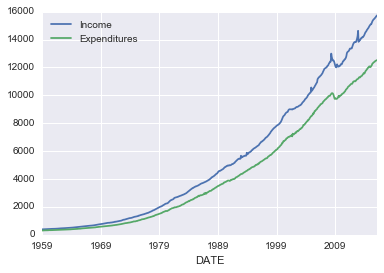

In [10]:
token = open('quandl.token').read()
data = Quandl.get(["FRED/PI", "FRED/PCE"], authtoken=token)
cols = {'FRED.PI - VALUE': 'Income', 'FRED.PCE - VALUE': 'Expenditures'}
data.rename(columns=cols, inplace=True)

print(data.tail())

data.plot()
plt.show()

              log(I)    log(C)
DATE                          
2015-11-01  9.652536  9.429877
2015-12-01  9.655116  9.431354
2016-01-01  9.659171  9.432884
2016-02-01  9.659937  9.434595
2016-03-01  9.663586  9.435610


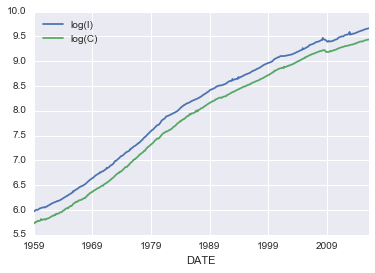

In [11]:
data_logs = data.apply(np.log).rename(columns={'Income': 'log(I)', 'Expenditures': 'log(C)'})

print(data_logs.tail())
data_logs.plot()
plt.show()

             Dlog(I)   Dlog(C)
DATE                          
2015-11-01  0.002606  0.003982
2015-12-01  0.002580  0.001476
2016-01-01  0.004056  0.001530
2016-02-01  0.000766  0.001712
2016-03-01  0.003648  0.001014
             Dlog(I)   Dlog(C)
DATE                          
1959-02-01  0.005088  0.011355
1959-03-01  0.007080  0.009950
1959-04-01  0.008030 -0.001598
1959-05-01  0.006477  0.012399
1959-06-01  0.006189  0.006613


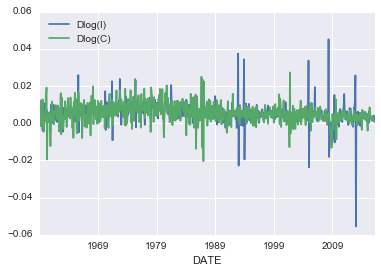

In [13]:
data_dlogs = data_logs.diff().dropna().rename(columns={'log(I)': 'Dlog(I)', 'log(C)': 'Dlog(C)'})

print(data_dlogs.tail())
print(data_dlogs.head())
data_dlogs.plot()
plt.show()

In [30]:
df3 = pd.merge(data_logs, data_dlogs, left_index=True, right_index=True)
df3 = pd.merge(df3, data_logs.shift(1),
               left_index=True, right_index=True, suffixes=('', '_lag'))
df3 = pd.merge(df3, data_dlogs.shift(1),
               left_index=True, right_index=True, suffixes=('', '_lag')).dropna()

print(df3.tail())

              log(I)    log(C)   Dlog(I)   Dlog(C)  log(I)_lag  log(C)_lag  \
DATE                                                                         
2015-11-01  9.652536  9.429877  0.002606  0.003982    9.649930    9.425895   
2015-12-01  9.655116  9.431354  0.002580  0.001476    9.652536    9.429877   
2016-01-01  9.659171  9.432884  0.004056  0.001530    9.655116    9.431354   
2016-02-01  9.659937  9.434595  0.000766  0.001712    9.659171    9.432884   
2016-03-01  9.663586  9.435610  0.003648  0.001014    9.659937    9.434595   

            Dlog(I)_lag  Dlog(C)_lag  
DATE                                  
2015-11-01     0.003085     0.001517  
2015-12-01     0.002606     0.003982  
2016-01-01     0.002580     0.001476  
2016-02-01     0.004056     0.001530  
2016-03-01     0.000766     0.001712  


In [34]:
exog = sm.add_constant(df3[['Dlog(C)_lag', 'Dlog(I)', 'log(I)_lag']])
model = sm.OLS(df3['Dlog(C)'], exog).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                Dlog(C)   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     27.17
Date:                Sun, 08 May 2016   Prob (F-statistic):           1.32e-16
Time:                        12:02:40   Log-Likelihood:                 2625.4
No. Observations:                 685   AIC:                            -5243.
Df Residuals:                     681   BIC:                            -5225.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const           0.0112      0.002      7.190      